#### DCGAN Architecture for Human Face Generation

## **Description:**

- We use variation of GAN, "DCGAN" (Deep Convolution Generative Adversarial Network) for human face gen
- Input(human faces) --> DCGAN --> output (random generated faces)
- Dataset : [Flickr Faces Dataset Resized](https://www.kaggle.com/datasets/matheuseduardo/flickr-faces-dataset-resized/data) from kaggle
- Image sizes in Dataset : 256x256 , 128x128, 64x64 each of 52,000 images/samples
- Recommended 64x64 size for 52k images due to gpu limitation, crases if not
- But ive tried 256x256 for lesser samples
- 64x64 input imgs contains noise --> output generated imgs also have blur/ noise
- 256x256 input imgs is HiRes --> output generated imgs also HiRes
- Implemented full project on kaggle 

## **DCGAN Concepts:**

- DCGAN is a variation/extension of GAN
- Has important 2 aspects/params :-
    1. Generator
    2. Discriminator
    - Both works against each other
    - Both are Neural Networks (multilayer perceptrons)

1. Generator :
- Will try to produce random images from training data

2. Discriminator :
- Will try to identify which one is real and which one is fake.
- Meaning whether the image that came to discriminator-model has come from original data distribution or from the generator-model (generated images / fake). - This is how disriminator tells difference between original-img(real) & generated-img(fake)
- In every training layer the discriminator will evolve to identify more & more minor differenes in the original & generated images , and with every improvement of discriminator the generator will also improve to produce more and more realistic images. 
- This is how both ats against each other and yet produce a proper output
- If discriminator is very powerful it supplies less confident scores to generato, resulting generator to not learn anything from training data, hence we make a powerful generator but a linear discriminator with less power

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

import os
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

2025-04-22 19:38:58.164392: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745350738.358298     381 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745350738.415276     381 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Data-Preprocessing

**Data-Preprocessing Steps:**
1. **Step-1:** Access images from base directory
2. **Step-2:** Convert images to RGB explicitly, just to make sure no img in gray scale
3. **Step-3:** Resize images
4. **Step-4:** Convert their dtype explicitly to float
5. **Step-5:** Normalize the data  between (-1, 1) (For generator & Discriminator)
- Generally we normalize the data between (0, 1) but as we are working with GAN's, we'll be normalizing it beween (-1, 1)
- GANs often work better when the input is normalized to a symmetrical range around zero. This helps the generator and discriminator networks to train more effectively since the data is centered around zero.

6. **Step-6:** Append the images in the folder

- os.walk() is used to simplify traversing directories and files.
Processes all files within subdirectories and skips directories automatically.

#### Image Hyper-Params 

In [2]:
# Image Hyper-Parameters
IMG_SIZE = 256 # Set Image parameters
NUM_IMGS = 10000
BUFFER_SIZE = 10000 # Max Limit The shuffle Imgs can be generated
BATCH_SIZE = 100 # Passing images to model in batche not individually 

##### Load Dataset

In [3]:
# Define Dataset Directory
DATA_DIR = '/kaggle/input/flickr-faces-dataset-resized/256x256/faces'

In [4]:
# Load Images & Preprocess Function
def load_preprocess_images(directory, img_size, limit=1000):
    images = []
    count = 0
    for sub_dir, _, files in os.walk(directory) : 
        """
        for loop helps us to traverse all files in dir, without any issues
        even if we encounter a folder inside faces/ it will skip that
        """
        # Data Preproessing steps:- 
        for file in files: 
            if count >= limit:
                break
                
            # Step-1: Access images from base directory
            file_path = os.path.join(sub_dir, file)
            
            try: 
                # Step-2: Convert images to RGB explicitly
                img = Image.open(file_path).convert('RGB')
                
                # Step-3: Resize images
                img = img.resize((img_size, img_size))
                
                # Step-4: Convert their dtype explicitly to float
                img_array = np.array(img).astype('float32')
                
                # Step-5: Normalize the data between (-1, 1) (For generator & Discriminator)
                img_array = (img_array - 511.5)/511.5 # 256X2 = 512 ~ 511.5

                # Step-6: Append the images in the folder
                images.append(img_array)

                count += 1
                
            except Exception as e:
                pass 
        if count >= limit:
                    break
    return np.array(images)

In [5]:
# Calling load_preprocess_images()
images_data = load_preprocess_images(DATA_DIR, IMG_SIZE, NUM_IMGS)

In [6]:
# Check Img Data
print(f"Num of Images     : {len(images_data)}")
print(f"images_data Dimen : {images_data.shape}") 
print(f"Images Dimen      : {images_data[0].shape}") # channel = 3 a RGB
print(f"Image Value       : {images_data[0]}")

Num of Images     : 10000
images_data Dimen : (10000, 256, 256, 3)
Images Dimen      : (256, 256, 3)
Image Value       : [[[-0.57380253 -0.5777126  -0.6089932 ]
  [-0.56793743 -0.5718475  -0.60117304]
  [-0.56402737 -0.56989247 -0.599218  ]
  ...
  [-0.95894426 -0.9608993  -0.9706745 ]
  [-0.9608993  -0.9608993  -0.9687194 ]
  [-0.9608993  -0.9608993  -0.9687194 ]]

 [[-0.57575756 -0.58162266 -0.61290324]
  [-0.56989247 -0.57575756 -0.60703814]
  [-0.5659824  -0.5718475  -0.60117304]
  ...
  [-0.95894426 -0.9608993  -0.9687194 ]
  [-0.95307916 -0.9569892  -0.96480936]
  [-0.9569892  -0.95894426 -0.9667644 ]]

 [[-0.5777126  -0.5855327  -0.61876833]
  [-0.5718475  -0.5777126  -0.61485827]
  [-0.56793743 -0.57380253 -0.60703814]
  ...
  [-0.95894426 -0.95894426 -0.9706745 ]
  [-0.9628543  -0.9608993  -0.9706745 ]
  [-0.9628543  -0.9608993  -0.9706745 ]]

 ...

 [[-0.943304   -0.94721407 -0.95894426]
  [-0.9374389  -0.94525903 -0.9550342 ]
  [-0.9315738  -0.94134897 -0.95307916]
  ...
  [

In [7]:
# Shuffle Dataset for randomness, model should learn data randomly not in ordered
train_dataset = tf.data.Dataset.from_tensor_slices(images_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
# from_tensor_slices --> converts data to tensor before shuffling and batching

I0000 00:00:1745350906.192105     381 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745350906.192801     381 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [8]:
# Train Dataset Type
type(train_dataset)

tensorflow.python.data.ops.batch_op._BatchDataset

### Data Visualization

In [10]:
# Vizualise First Few Images
img_files = os.listdir(DATA_DIR)[:9] # First 9 Images from from main Dataset

HiRes Clear Images [as images are 256x256] : 


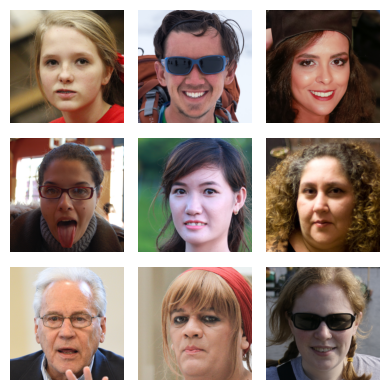

In [11]:
# Create Subplot
fig, axes = plt.subplots(3,3,figsize = (4,4))
print("HiRes Clear Images [as images are 256x256] : ")
for i, img_file in enumerate(img_files):
    img_path = os.path.join(DATA_DIR, img_file)

    # Open the Image File
    img = Image.open(img_path)

    # displaying images as 2D
    row = i // 3
    col = i % 3
    
    # Display the Image
    axes[row, col].imshow(img)
    axes[row, col].axis('off')
    
plt.tight_layout()
plt.show() 

### Build DCGAN Model

##### Model Architecture Concept

- Create two models : (1) Generator & (2) Discriminator
- Both are Neural Net / Multi-layer perceptron
- A generator ("the artist") learns to create images that look real
- A discriminator ("the art critic") learns to tell real images apart from fakes.
- During training, the generator progressively becomes better at creating images that look real, while the discriminator becomes better at telling them apart
- The process reaches equilibrium when the discriminator can no longer distinguish real images from fakes.
- Generator & Discriminator will be 2 seprate neural networks
- We use 'ReLu'act func for all layers of generator, except the output layer
- Output Layer will have 'tanh' act func for any GAN
- We use 'LeakyReLu' act func *after batch norm* for all layers of Discriminator, except the output layer
  
**(1) THE GENERATOR MODEL :**
- A generator ("the artist") learns to create images that look real
- 3 Components of Generator
   1. **DENSE LAYER**
   2. **TRANSPOSED CONVOLUTIONS**
   3. **FINAL LAYER**
  
**GENERATOR MODEL ALGORITHM**
1. The generator uses tf.keras.layers.Conv2DTranspose (upsampling) layers to produce an image from a seed (random noise)
2. Start with a Dense layer that takes this seed as input, then upsample several times until you reach the desired image size of 256x256x3
3. LeakyReLU activation for each layer, except the output layer which uses tanh.

**1. DENSE LAYER :**
1. Spatial Dimension - 8 x 8
2. Channel Depth - 512 

**Latent Vector** = (8, 8, 512)

**2. TRANSPOSED CONVOLUTIONS :**
1. Initially, Upsample from 8x8 to 16x16: 256 channels.
2. Seondly, Upsample from 16x16 to 32x32: 128 channels.
3. Thridly, Upsample from 32x32 to 64x64: 64 channels. (for 64x64 imgs, would stop here)
4. Fourthly, Upsample from 64x64 to 128x128: 32 channels.
5. Fifthly, Upsample from 128x128 to 256x256: 16 channels.
   
**3. FINAL LAYER:**
-Produces a 64x64x3 image (3 channels for RGB).


#### Build Model : Generator

In [12]:
LATENT_DIM = 100 # Higher value for producing more variable results, 100 is mid

def generator_model():
    model = tf.keras.Sequential([
        
        # 1. Dense Layer of Random Noise
        tf.keras.layers.Dense(8*8*512, input_dim = LATENT_DIM, activation = 'relu'),
        tf.keras.layers.BatchNormalization(), # Batch Norm Layer

        # Convert 1D --> 3D
        tf.keras.layers.Reshape((8, 8, 512)),

        # 2.1 - 1st Transposed Convolution (layer-1) 
        tf.keras.layers.Conv2DTranspose(filters = 256, kernel_size= (4,4), strides = (2,2), padding = 'same', activation = 'relu'),
        tf.keras.layers.BatchNormalization(), # Batch Norm Layer

        # 2.2 - 2nd Transposed Convolution (layer-2) 
        tf.keras.layers.Conv2DTranspose(filters = 128, kernel_size= (4,4), strides = (2,2), padding = 'same', activation = 'relu'),
        tf.keras.layers.BatchNormalization(), # Batch Norm Layer

        # 2.3 - 3rd Transposed Convolution (layer-3) 
        tf.keras.layers.Conv2DTranspose(filters = 64, kernel_size= (4,4), strides = (2,2), padding = 'same', activation = 'relu'),
        tf.keras.layers.BatchNormalization(), # Batch Norm Layer

        # 2.4 - 4th Transposed Convolution (layer-4) 
        tf.keras.layers.Conv2DTranspose(filters = 32, kernel_size= (4,4), strides = (2,2), padding = 'same', activation = 'relu'),
        tf.keras.layers.BatchNormalization(), # Batch Norm Layer

        # 2.5 - 5th Transposed Convolution (layer-5) 
        tf.keras.layers.Conv2DTranspose(filters = 16, kernel_size= (4,4), strides = (2,2), padding = 'same', activation = 'relu'),
        tf.keras.layers.BatchNormalization(), # Batch Norm Layer

        # 3. Output Layer
        tf.keras.layers.Conv2D(3,  kernel_size= (4,4), padding = 'same', activation = 'tanh') # 3 = RGB
    ])
    
    return model

# Calling the Generator Model
generator = generator_model()

In [13]:
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32768)               │       3,309,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32768)               │         131,072 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 256)         │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 128)         │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 64)          │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 128, 128, 32)        │          32,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 256, 256, 16)        │           8,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 256, 256, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 256, 256, 3)         │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,237,363 (23.79 MB)

 Trainable params: 6,170,835 (23.54 MB)

 Non-trainable params: 66,528 (259.88 KB)

#### Build Model : Discriminator

**(1) THE DISCRIMINATOR MODEL :**
- Basically a neural net like Generator, but with a different objective
- CNN based image classifier identifies between real images vs fakes. 
- A discriminator ("the art critic") learns to tell real images apart from fakes.
- Just reverse the layers of tf.keras.sequential in generator() for the discriminator()
- 3 Components of Discriminator
   1. **Convolutions**
   2. **Flatten Layer - Drop out layer**
   3. **LAYER**
  
**1. CONVOLUTIONS :** - *Reverse order of generator() ttransposed convolutions*
1. Firstly, Upsample from 128x128 to 256x256: 16 channels
2. Secondly, Upsample from 64x64 to 128x128: 32 channels
3. Thridly, Upsample from 32x32 to 64x64: 64 channels (for 64x64 imgs, would stop here)
4. Fourthly, Upsample from 16x16 to 32x32: 128 channels
5. Fifthly, Upsample from 8x8 to 16x16: 256 channels

  
**3. FINAL LAYER:**
-Produces a 64x64x3 image (3 channels for RGB).


In [15]:
INPUT_SHAPE = (256, 256, 3)

# Creating Discriminator Model
def discriminator_model():
    model = tf.keras.Sequential([

        # can alssso add a layer of 512 filters, but that makes disc more powerful, we want a linear disc 
        # 1.1 - 1st Transposed Convolution (layer-1) 
        tf.keras.layers.Conv2D(16, (4,4), strides = (2,2), padding = 'same', input_shape = INPUT_SHAPE), # keyword args also work, inputshape only in 1st layer
        tf.keras.layers.BatchNormalization(), # Batch Norm Layer
        tf.keras.layers.LeakyReLU(), # act func after batch norm layer

         # 1.2 - 2nd Transposed Convolution (layer-2) 
        tf.keras.layers.Conv2D(32, (4,4), strides = (2,2), padding = 'same'), 
        tf.keras.layers.BatchNormalization(), # Batch Norm Layer
        tf.keras.layers.LeakyReLU(), # act func after batch norm layer
       
         # 1.3 - 3rd Transposed Convolution (layer-3) 
        tf.keras.layers.Conv2D(64, (4,4), strides = (2,2), padding = 'same'), 
        tf.keras.layers.BatchNormalization(), # Batch Norm Layer
        tf.keras.layers.LeakyReLU(), # act func after batch norm layer
       
         # 1.4 - 4th Transposed Convolution (layer-4) 
        tf.keras.layers.Conv2D(128, (4,4), strides = (2,2), padding = 'same'), 
        tf.keras.layers.BatchNormalization(), # Batch Norm Layer
        tf.keras.layers.LeakyReLU(), # act func after batch norm layer
       
         # 1.5 - 5th Transposed Convolution (layer-5) 
        tf.keras.layers.Conv2D(256, (4,4), strides = (2,2), padding = 'same'), 
        tf.keras.layers.BatchNormalization(), # Batch Norm Layer
        tf.keras.layers.LeakyReLU(), # act func after batch norm layer

        # 2. Flatten Layer + Dropout Layer
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3), # In every Hidden Layer the model switch off 30% neurons to stop overfitting

        # 3. Output Layer
        tf.keras.layers.Dense(1, activation = 'sigmoid'),# Bin-Clf task of Discr identifie either (fake or true) so 1
    
    ])
    
    return model

# Calling discriminator()
discriminator = discriminator_model()

In [16]:
# Check discriminator() summary
discriminator.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 128, 128, 16)        │             784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 128, 128, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 64, 64, 32)          │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 64)          │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 16, 16, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 8, 8, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │          16,385 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 715,953 (2.73 MB)

 Trainable params: 714,961 (2.73 MB)

 Non-trainable params: 992 (3.88 KB)

### Loss Function & Optimizers

**Generator Loss & Discriminator Loss**
- Defining loss functions and optimizers for both models as both are separate models & funcs
- We're using BinaryCrossentropy as our loss function, as the discriminator will have either of two (binary) output -> Determining whether the generated image by Generator is real or fake

In [18]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

**DISCIMINATOR LOSS**
- This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [20]:
# Discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output) # pass 1s array that looks like a real output
    # tf.ones_like(real_output) = noise array that look like real output

    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) # pass 0s array that looks like a fake output
    # tf.zeros_like(fake_output) = noise array that look like fakee output

    total_loss = real_loss + fake_loss

    return total_loss

**GENERATOR LOSS**
- The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [21]:
# Generator loss 
def generator_loss(fake_output):
    """
    Only pass fake_output, because if the discr clasifies any img as fake that output 
    will be passed here, and based on this the generator will try to improve itself
    The generator will try how good to imporve itself so that the discriminator model
    wont be able to guess that the image was fake
    """

    return cross_entropy(tf.ones_like(fake_output), fake_output)

**OPTIMIZERS**
- Generator & Discriminator both will have different optimizers as we're training both models seperately
Using Adam optimizer

In [22]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = (1e-4))
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = (1e-4))

### Training

In [29]:
EPOCHS = 80 
noise_dim = 100 # Batch of random noise is generated with norm dist, goes as input to the gen, 100 is size of random noise vect
num_generated_images = 16
seed = tf.random.normal([num_generated_images, noise_dim])

In [30]:
# Training Loop
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    # GradientTape records the ops on models during forward prop, computes gradients helps in backprop
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: 
        generated_images = generator(noise, training = True)

        real_output = discriminator(images, training = True)
        fake_output = discriminator(generated_images, training = True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))



In [31]:
# Generate & save image
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False) # prediction part no training so False
    predictions = (predictions + 1) / 2.0

    # Plot Predictions
    fig = plt.figure(figsize=(6, 6))
    for i in range(predictions.shape[0]):
        plt.subplot(6, 6, i+1)
        plt.imshow(predictions[i])
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch)) # will be saved in kaggle output directory
    plt.close()


In [32]:
def train(dataset, epochs):
    for epoch in range(epochs):
        print(f'Starting epoch {epoch+1}/{epochs}')
        for image_batch in dataset:
            train_step(image_batch)
        generate_and_save_images(generator, epoch + 1, seed)  # Use the generator model, not the function

In [33]:
# train the model
train(train_dataset, EPOCHS)

Starting epoch 1/80


I0000 00:00:1745351077.161083     416 cuda_dnn.cc:529] Loaded cuDNN version 90300


Starting epoch 2/80
Starting epoch 3/80
Starting epoch 4/80
Starting epoch 5/80
Starting epoch 6/80
Starting epoch 7/80
Starting epoch 8/80
Starting epoch 9/80
Starting epoch 10/80
Starting epoch 11/80
Starting epoch 12/80
Starting epoch 13/80
Starting epoch 14/80
Starting epoch 15/80
Starting epoch 16/80
Starting epoch 17/80
Starting epoch 18/80
Starting epoch 19/80
Starting epoch 20/80
Starting epoch 21/80
Starting epoch 22/80
Starting epoch 23/80
Starting epoch 24/80
Starting epoch 25/80
Starting epoch 26/80
Starting epoch 27/80
Starting epoch 28/80
Starting epoch 29/80
Starting epoch 30/80
Starting epoch 31/80
Starting epoch 32/80
Starting epoch 33/80
Starting epoch 34/80
Starting epoch 35/80
Starting epoch 36/80
Starting epoch 37/80
Starting epoch 38/80
Starting epoch 39/80
Starting epoch 40/80
Starting epoch 41/80
Starting epoch 42/80
Starting epoch 43/80
Starting epoch 44/80
Starting epoch 45/80
Starting epoch 46/80
Starting epoch 47/80
Starting epoch 48/80
Starting epoch 49/80


### Model Evaluation

##### Visualizing Generated Images

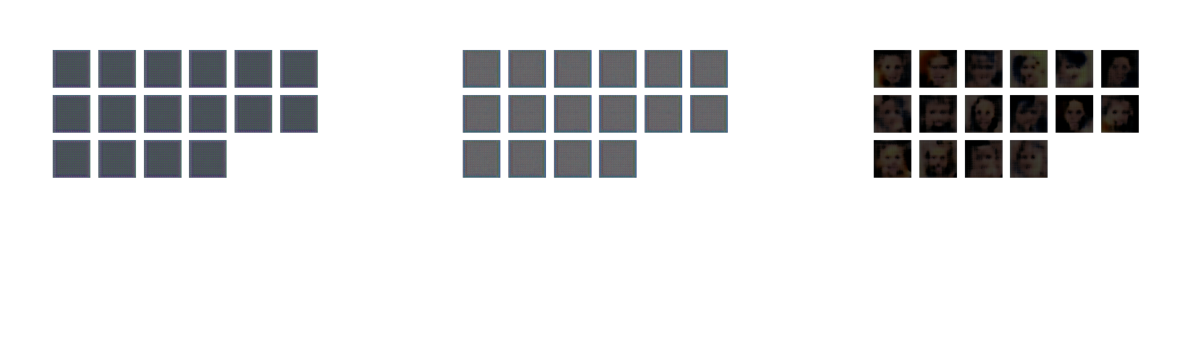

In [42]:
# VISUALIZING GENERATED IMAGES (ANY 3)
import random
image_folder = '/kaggle/working/'

# Get a list of all image file paths in the folder
image_paths = [os.path.join(image_folder, file) for file in os.listdir(image_folder) if file.endswith(('.png', '.jpg', '.jpeg'))]

# Select 3 random images from the list
random_images = random.sample(image_paths, 3)

# Create a figure to display the images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Display each random image
for ax, img_path in zip(axes, random_images):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')

In [ ]:
# make all images zip

import shutil

shutil.make_archive('/kaggle/working/', 'zip', '/kaggle/working/')


In [46]:
import zipfile

output_dir = '/kaggle/working/'
zip_path = '/kaggle/working/images.zip'

with zipfile.ZipFile(zip_path, 'w') as zipf:
    for root, dirs, files in os.walk(output_dir):
        for file in files:
            if file.endswith('.png'):
                full_path = os.path.join(root, file)
                zipf.write(full_path, arcname=os.path.relpath(full_path, output_dir))

In [ ]:
#!rm -rf /kaggle/working/* # formats kaggle output Dir